In [1]:
import numpy as np
from joblib import load
from scipy.sparse import vstack, hstack, csr_matrix
from scipy.stats import sem, mannwhitneyu
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, roc_auc_score
import xgboost

In [2]:
data_version=0

In [3]:
data = load(f'./data/gp_comments/data_vectorized_revealed_25k_{data_version}.sav')
data_headers_dict = load(f'./data/gp_comments/data_headers_{data_version}.sav')['vocabulary_']
labels = load(f'./data/gp_comments/labels_revealed_25k_{data_version}.sav')
print(len(data))
print(len(labels))
print(len(data_headers_dict))

25000
25000
2511


In [4]:
labels = np.asarray(labels, dtype=object)
print(len(labels))

data = np.array(data)
print(len(data))

headers = sorted(data_headers_dict.keys(), key=lambda key: data_headers_dict[key])
headers_concurrent = list(map(lambda h: f'{h}_concurrent', headers))
print(len(headers), len(headers_concurrent))

25000
25000
2511 2511


In [5]:
def reveal_spase(sparse_list):
    return vstack(sparse_list, format='csr')

def reveal_np(np_list):
    return np.concatenate(np_list, axis=0)

def reveal_set(data_, labels_):
    return reveal_spase(data_), reveal_np(labels_)

In [6]:
class CustomEstimator:
    def __init__(self, model=None, early_stopping=False):
        self.model = model
        self.early_stopping = early_stopping

    def fit(self, X, Y=None, **kwargs):
        train_data_revealed, train_labels_revealed = reveal_set(X, Y)
        kwargs = {}
        if self.early_stopping:
            kwargs['eval_set'] = [(train_data_revealed, train_labels_revealed)]
        self.model.fit(train_data_revealed, train_labels_revealed, **kwargs)

        if self.early_stopping:
            self.model.set_params(n_estimators=self.model.best_ntree_limit)

        return self

    def get_params(self, deep=False):
        return {'model': self.model, 'early_stopping': self.early_stopping}

    def set_params(self, **kwargs):
        self.model.set_params(**kwargs)

        return self

In [7]:
def evaluate(estimator, test_data_list, test_labels_list):
    """Evaluate estimator on each document from `test_data_list`

    :param estimator: sklearn estimator
    :param test_data_list: list of sparce matrices
    :param test_labels_list: 2d list of labels
    :return: precision and roc-auc scores (calculates by macro-averaging corresponding scores of each document)
    """
    precision_batch = []
    roc_auc_batch = []
    for test_data_batch, test_labels_batch in zip(test_data_list, test_labels_list):
        positive_class_proba = estimator.model.predict_proba(test_data_batch)[:, 1]

        max_p_idx = np.argmax(positive_class_proba)
        predicted_labels_batch = [0] * len(positive_class_proba)
        predicted_labels_batch[max_p_idx] = 1
        if len(test_labels_batch) == 1:
            print(test_labels_batch)
        precision_batch.append(precision_score(test_labels_batch, predicted_labels_batch))
        roc_auc_batch.append(roc_auc_score(test_labels_batch, positive_class_proba))

    return {
        'precision': np.average(precision_batch),
        'roc-auc': np.average(roc_auc_batch)
    }

In [8]:
def repeated_cross_validation(estimator, X, y, cv=None, k=10, r=7, random_state=42, verbose=1):
    if cv is None:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=random_state)
    result = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        scoring=evaluate,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True,
        return_estimator=True,
        error_score='raise',
    )

    return result

In [9]:
def repeated_grid_search(estimator, param_grid, X, y, cv=None, k=10, r=7, random_state=42, verbose=1):
    if cv is None:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=random_state)
    clf = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=evaluate,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True,
        error_score='raise',
        refit='precision',
    )
    clf.fit(X, y)

    return clf

In [10]:
def statistics_from_cv(cv_result):
    scores_precision = cv_result['test_precision']
    scores_roc_auc = cv_result['test_roc-auc']

    return {
        'precision mean': np.mean(scores_precision),
        'precision sem': sem(scores_precision),
        'roc-auc mean': np.mean(scores_roc_auc),
        'roc-auc sem': sem(scores_roc_auc),
    }

In [11]:
def compare_estimators(estimator_base, estimator_concurrent, data_base, data_concurrent_, labels_, cv=None, k=10, r=7, verbose=1, critical_value=0.05):
    cv_results_base = repeated_cross_validation(estimator_base, data_base, labels_, cv=cv, verbose=verbose, r=r, k=k)
    stats_base = statistics_from_cv(cv_results_base)

    cv_results_concurrent = repeated_cross_validation(estimator_concurrent, data_concurrent_, labels_, cv=cv, verbose=verbose,  r=r, k=k)
    stats_concurrent = statistics_from_cv(cv_results_concurrent)

    u_statistic_precision, p_value_precision = mannwhitneyu(cv_results_base['test_precision'], cv_results_concurrent['test_precision'])
    u_statistic_roc_auc, p_value_roc_auc = mannwhitneyu(cv_results_base['test_roc-auc'], cv_results_concurrent['test_roc-auc'])

    return {
        'mannwhitneyu_precision': {
            'u_statistic': u_statistic_precision,
            'p_value': p_value_precision,
            'is_mean_different': bool(p_value_precision < critical_value),
        },
        'mannwhitneyu_roc_auc': {
            'u_statistic': u_statistic_roc_auc,
            'p_value': p_value_roc_auc,
            'is_mean_different': bool(p_value_roc_auc < critical_value),
        },
        'base': {
            **stats_base,
            'cv_results': cv_results_base,
        },
        'concurrent': {
            **stats_concurrent,
            'cv_results': cv_results_concurrent,
        },
    }

In [12]:
def compare_data(estimator, data_base, data_concurrent_, labels_, k=10, r=7, verbose=1, critical_value=0.05):
    return compare_estimators(estimator, estimator, data_base, data_concurrent_, labels_, k, r, verbose, critical_value)

In [13]:
def doc_concurrent_data(doc, binarize=False):
    """
    Convert list of candidates, to list of concurrent candidates
    :arg doc - list of candidates in format of scipy.sparse.csr.csr_matrix
    :arg binarize - whether to binarize each of concurrent candidates
    :returns - list of concurrent candidates in format of scipy.sparse.csr.csr_matrix
    """
    concurrent_list = []
    n = doc.shape[0]
    for idx, candidate in enumerate(doc):
        concurrent_mask = [True] * n
        concurrent_mask[idx] = False
        concurrent_candidates = doc[concurrent_mask]
        concurrent = concurrent_candidates.sum(axis=0)
        if binarize:
            concurrent[concurrent > 0] = 1
        concurrent = csr_matrix(concurrent)
        concurrent_list.append(concurrent)

    concurrent_sparse = reveal_spase(concurrent_list)
    result = hstack([doc, concurrent_sparse], format='csr')

    return result

In [15]:
data_concurrent = list(map(doc_concurrent_data, data))

In [16]:
data_concurrent_binarized = list(map(lambda it: doc_concurrent_data(it, True), data))

In [17]:
train_indices, test_indices = train_test_split(range(len(data)), test_size=0.25, random_state=42)
len(train_indices), len(test_indices)

(18750, 6250)

In [18]:
import json
from copy import deepcopy

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save(res, file_name:str):
    with open(f'./data/output/gp_comments/{file_name}', 'w+') as f:
        dump_json = deepcopy(res)
        del dump_json['base']['cv_results']['estimator']
        del dump_json['concurrent']['cv_results']['estimator']
        json.dump(dump_json, f, cls=NumpyEncoder, indent=4)

In [19]:
from sklearn.linear_model import LogisticRegression
log_reg_gscv = LogisticRegression(verbose=1, warm_start=False, n_jobs=-1)
estimator_log_reg_gscv = CustomEstimator(log_reg_gscv)

In [22]:
params = [
    {
    'solver': ['liblinear'],
    'C': [2],
    'penalty': ['l2']
},
    {
    'solver': ['saga'],
    'C': [5],
    'penalty': ['elasticnet'],
    'l1_ratio': [1]
}
]
result_log_reg_gscv = repeated_grid_search(estimator_log_reg_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_log_reg_gscv.best_params_)
print(result_log_reg_gscv.cv_results_)

Fitting 1 folds for each of 2 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 100 epochs took 85 seconds
max_iter reached after 85 seconds
{'C': 5, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'}
{'mean_fit_time': array([ 0.62604642, 63.14233327]), 'std_fit_time': array([0., 0.]), 'mean_score_time': array([7.84134507, 7.26801658]), 'std_score_time': array([0., 0.]), 'param_C': masked_array(data=[2, 5],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_penalty': masked_array(data=['l2', 'elasticnet'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['liblinear', 'saga'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_l1_ratio': masked_array(data=[--, 1],
             mask=[ True, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}, {'C': 5, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'}], 'split0_test_precis

D:\Education\Diploma\ConcurrentClassification\venv\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


In [29]:
params = [{
    'solver': ['liblinear'],
    'C': [10],
    'penalty': ['l1']
},
]
result_log_reg_gscv = repeated_grid_search(estimator_log_reg_gscv, params, data_concurrent, labels, cv=[(train_indices, test_indices)])
print(result_log_reg_gscv.best_params_)
print(result_log_reg_gscv.cv_results_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


D:\Education\Diploma\ConcurrentClassification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


[LibLinear]{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
{'mean_fit_time': array([24.27617717, 11.22413898, 21.43113995, 16.20507383]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([10.16299891, 12.35099053, 10.72899437, 11.58800197]), 'std_score_time': array([0., 0., 0., 0.]), 'param_C': masked_array(data=[9, 10, 11, 12],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 9, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 11, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 12, 'penalty': 'l1', 'solver': 'liblin

In [20]:
log_reg_base = LogisticRegression(penalty='l2', C=2, solver='liblinear')
log_reg_concurrent = LogisticRegression(penalty='l2', C=10, solver='liblinear')
result_log_reg_tuned = compare_estimators(CustomEstimator(log_reg_base), CustomEstimator(log_reg_concurrent), data, data_concurrent, labels, k=4, r=1)
save(result_log_reg_tuned, 'result_log_reg_tuned.json')
result_log_reg_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   37.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   46.2s finished


{'mannwhitneyu_precision': {'u_statistic': 0.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 0.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'base': {'precision mean': 0.81028,
  'precision sem': 0.0035821036649805083,
  'roc-auc mean': 0.941652129165288,
  'roc-auc sem': 0.0017378907495091238,
  'cv_results': {'fit_time': array([0.60900402, 0.6099956 , 0.6030302 , 0.52896237]),
   'score_time': array([8.29299974, 8.25700378, 8.32596993, 8.26200414]),
   'estimator': [<__main__.CustomEstimator at 0x18e4e425730>,
   'test_precision': array([0.82032, 0.80992, 0.8072 , 0.80368]),
   'train_precision': array([0.83861333, 0.83834667, 0.84442667, 0.84672   ]),
   'test_roc-auc': array([0.94648794, 0.93890935, 0.94185959, 0.93935163]),
   'train_roc-auc': array([0.95628695, 0.95679964, 0.95926347, 0.96022678])}},
 'concurrent': {'precision mean': 0.9056,
  'precision sem': 0.0023623716896373406,
  'roc-auc mean'

In [34]:
from sklearn.naive_bayes import MultinomialNB
mnb_gscv = MultinomialNB()
estimator_mnb_gscv = CustomEstimator(mnb_gscv)

In [38]:
params = {
    'alpha': [0.001]
}
result_mnb_gscv = repeated_grid_search(estimator_mnb_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_mnb_gscv.best_params_)
print(result_mnb_gscv.cv_results_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'alpha': 0.0005}
{'mean_fit_time': array([0.61499643, 0.3700304 , 0.35796452]), 'std_fit_time': array([0., 0., 0.]), 'mean_score_time': array([8.40647602, 8.41734338, 8.36838198]), 'std_score_time': array([0., 0., 0.]), 'param_alpha': masked_array(data=[0.0005, 0.001, 0.005],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.0005}, {'alpha': 0.001}, {'alpha': 0.005}], 'split0_test_precision': array([0.82016, 0.82016, 0.81984]), 'mean_test_precision': array([0.82016, 0.82016, 0.81984]), 'std_test_precision': array([0., 0., 0.]), 'rank_test_precision': array([1, 1, 3]), 'split0_train_precision': array([0.84805333, 0.84794667, 0.84789333]), 'mean_train_precision': array([0.84805333, 0.84794667, 0.84789333]), 'std_train_precision': array([0., 0., 0.]), 'split0_test_roc-auc': array([0.94710853, 0.94710853, 0.94700719]), 'mean_test_roc-auc': array([0.94710853, 0.9471085

In [40]:
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}
result_mnb_gscv = repeated_grid_search(estimator_mnb_gscv, params, data_concurrent_binarized, labels, cv=[(train_indices, test_indices)])
print(result_mnb_gscv.best_params_)
print(result_mnb_gscv.cv_results_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
{'alpha': 0.01}
{'mean_fit_time': array([0.31400204, 0.33499694, 0.32700515, 0.32600141]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([8.4727273 , 8.93573213, 9.01369166, 9.17471719]), 'std_score_time': array([0., 0., 0., 0.]), 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.0001}, {'alpha': 0.001}, {'alpha': 0.01}, {'alpha': 0.1}], 'split0_test_precision': array([0.80944, 0.80944, 0.80976, 0.8072 ]), 'mean_test_precision': array([0.80944, 0.80944, 0.80976, 0.8072 ]), 'std_test_precision': array([0., 0., 0., 0.]), 'rank_test_precision': array([2, 2, 1, 4]), 'split0_train_precision': array([0.83653333, 0.83648   , 0.83637333, 0.83504   ]), 'mean_train_precision': array([0.83653333, 0.83648   , 0.83637333, 0.83504   ]), 'std_train_precision': array([0., 0., 0., 0.]), 'split0_

In [41]:
mnb_base = MultinomialNB(alpha=0.001)
mnb_concurrent = MultinomialNB(alpha=0.01)
result_mnb_tuned = compare_estimators(CustomEstimator(mnb_base), CustomEstimator(mnb_concurrent), data, data_concurrent_binarized, labels, k=4, r=1)
save(result_mnb_tuned, 'result_mnb_tuned.json')
result_mnb_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   36.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   41.9s finished


{'mannwhitneyu_precision': {'u_statistic': 16.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 13.0,
  'p_value': 0.2,
  'is_mean_different': False},
 'base': {'precision mean': 0.8144800000000001,
  'precision sem': 0.0020917616180307535,
  'roc-auc mean': 0.9435756519815155,
  'roc-auc sem': 0.0013793288206691856,
  'cv_results': {'fit_time': array([0.36700296, 0.29700232, 0.30600452, 0.40496778]),
   'score_time': array([8.72520757, 8.57121038, 8.45920753, 8.37720466]),
   'estimator': [<__main__.CustomEstimator at 0x1a665c064f0>,
   'test_precision': array([0.82016, 0.81504, 0.81088, 0.81184]),
   'train_precision': array([0.84794667, 0.84629333, 0.85072   , 0.85162667]),
   'test_roc-auc': array([0.94710853, 0.94037231, 0.94354066, 0.94328111]),
   'train_roc-auc': array([0.96081311, 0.96149043, 0.96283694, 0.96285548])}},
 'concurrent': {'precision mean': 0.8018000000000001,
  'precision sem': 0.0030325346933986882,
  'ro

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_gscv = KNeighborsClassifier(n_jobs=-1)
estimator_knn_gscv = CustomEstimator(knn_gscv)

In [20]:
params = {
    'n_neighbors': [10, 15, 20],
    'weights': ['uniform']
}
result_knn_gscv = repeated_grid_search(estimator_knn_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_knn_gscv.best_params_)
print(result_knn_gscv.cv_results_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'n_neighbors': 15, 'weights': 'uniform'}
{'mean_fit_time': array([0.37599826, 0.42596388, 0.47400045]), 'std_fit_time': array([0., 0., 0.]), 'mean_score_time': array([288.59274077, 289.3097403 , 288.84874034]), 'std_score_time': array([0., 0., 0.]), 'param_n_neighbors': masked_array(data=[10, 15, 20],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'uniform', 'uniform'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 10, 'weights': 'uniform'}, {'n_neighbors': 15, 'weights': 'uniform'}, {'n_neighbors': 20, 'weights': 'uniform'}], 'split0_test_precision': array([0.69216, 0.71744, 0.70416]), 'mean_test_precision': array([0.69216, 0.71744, 0.70416]), 'std_test_precision': array([0., 0., 0.]), 'rank_test_precision': array([3, 1, 2]), 'split0_train_precision': array([0.69605

In [22]:
params = {
    'n_neighbors': [3, 5, 9],
    'weights': ['uniform']
}
result_knn_gscv = repeated_grid_search(estimator_knn_gscv, params, data_concurrent_binarized, labels, cv=[(train_indices, test_indices)])
print(result_knn_gscv.best_params_)
print(result_knn_gscv.cv_results_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'n_neighbors': 3, 'weights': 'uniform'}
{'mean_fit_time': array([0.33397126, 0.33394742, 0.49199963]), 'std_fit_time': array([0., 0., 0.]), 'mean_score_time': array([676.99824715, 667.59524536, 669.63225031]), 'std_score_time': array([0., 0., 0.]), 'param_n_neighbors': masked_array(data=[3, 5, 9],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'uniform', 'uniform'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 3, 'weights': 'uniform'}, {'n_neighbors': 5, 'weights': 'uniform'}, {'n_neighbors': 9, 'weights': 'uniform'}], 'split0_test_precision': array([0.63968, 0.62032, 0.60272]), 'mean_test_precision': array([0.63968, 0.62032, 0.60272]), 'std_test_precision': array([0., 0., 0.]), 'rank_test_precision': array([1, 2, 3]), 'split0_train_precision': array([0.84069333, 0.

In [23]:
knn_base = KNeighborsClassifier(n_jobs=-1, n_neighbors=15, weights='uniform')
knn_concurrent = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='uniform')
result_knn_tuned = compare_estimators(CustomEstimator(knn_base), CustomEstimator(knn_concurrent), data, data_concurrent_binarized, labels, k=4, r=1)
save(result_knn_tuned, 'result_knn_tuned.json')
result_knn_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 26.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 55.2min finished


{'mannwhitneyu_precision': {'u_statistic': 16.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 16.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'base': {'precision mean': 0.7150799999999999,
  'precision sem': 0.003802805981552738,
  'roc-auc mean': 0.8816480684975275,
  'roc-auc sem': 0.003553233772794916,
  'cv_results': {'fit_time': array([0.23799992, 0.26500487, 0.35999799, 0.42099667]),
   'score_time': array([385.47263741, 384.26685762, 387.72856426, 387.32956648]),
   'estimator': [<__main__.CustomEstimator at 0x24d21005760>,
   'test_precision': array([0.70592, 0.71296, 0.724  , 0.71744]),
   'train_precision': array([0.71978667, 0.74032   , 0.76042667, 0.75008   ]),
   'test_roc-auc': array([0.877027  , 0.87627874, 0.89171365, 0.88157289]),
   'train_roc-auc': array([0.88747476, 0.89162217, 0.91205714, 0.89807481])}},
 'concurrent': {'precision mean': 0.6302,
  'precision sem': 0.00157361579385398

In [18]:
from sklearn.svm import SVC
svc_gscv = SVC(probability=True, random_state=42)
estimator_svc_gscv = CustomEstimator(svc_gscv)

In [27]:
params = {
    'C': [1, 3, 5, 10],
    'gamma': ['scale']
}
result_svc_gscv = repeated_grid_search(estimator_svc_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_svc_gscv.best_params_)
print(result_svc_gscv.cv_results_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
{'C': 5, 'gamma': 'scale'}
{'mean_fit_time': array([1880.57003212, 1933.49800396, 1925.59830022, 1930.14729834]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([47.60399795, 48.07704139, 48.30601311, 48.29501867]), 'std_score_time': array([0., 0., 0., 0.]), 'param_C': masked_array(data=[1, 3, 5, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'gamma': 'scale'}, {'C': 3, 'gamma': 'scale'}, {'C': 5, 'gamma': 'scale'}, {'C': 10, 'gamma': 'scale'}], 'split0_test_precision': array([0.41568, 0.4024 , 0.44448, 0.41024]), 'mean_test_precision': array([0.41568, 0.4024 , 0.44448, 0.41024]), 'std_test_precision': array([0., 0., 0., 0.]), 'rank_test_precision': array([2, 4, 1, 3])

In [ ]:
params = {
    'C': [1, 3, 5, 10],
    'gamma': ['scale']
}
result_svc_gscv = repeated_grid_search(estimator_svc_gscv, params, data_concurrent, labels, cv=[(train_indices, test_indices)])
print(result_svc_gscv.best_params_)
print(result_svc_gscv.cv_results_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


In [ ]:
svc_base = SVC(probability=True, random_state=42, C=5, gamma='auto')
svc_concurrent = SVC(probability=True, random_state=42, C=1, gamma='auto')
result_svc_tuned = compare_estimators(CustomEstimator(svc_base), CustomEstimator(svc_concurrent), data, data_concurrent, labels, k=4, r=1)
save(result_svc_tuned, 'result_svc_tuned.json')
result_svc_tuned

In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc_gscv = DecisionTreeClassifier(random_state=42)
estimator_dtc_gscv = CustomEstimator(dtc_gscv)

In [29]:
params = [
    {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2],
},
    {
    'criterion': ['entropy'],
    'max_depth': [1200],
},
{
    'criterion': ['entropy'],
    'min_samples_split': [2],
},
    {
    'criterion': ['entropy'],
    'max_features': [0.1],
}
]
result_dtc_gscv = repeated_grid_search(estimator_dtc_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_dtc_gscv.best_params_)
print(result_dtc_gscv.cv_results_)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
{'criterion': 'entropy', 'max_depth': 1200}
{'mean_fit_time': array([5.43163371, 5.71962285, 5.24461865, 5.14661789, 1.94163585]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([8.93437719, 9.17056036, 9.13255477, 9.20661092, 9.26843834]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_criterion': masked_array(data=['gini', 'entropy', 'entropy', 'entropy', 'entropy'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[2, 2, --, --, --],
             mask=[False, False,  True,  True,  True],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[--, --, 1200, --, --],
             mask=[ True,  True, False,  True,  True],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[--, --, --, 2, --],
             mask=[ True,  True, 

In [38]:
params = [
{
    'criterion': ['entropy'],
    'min_samples_leaf': [2],
},
{
    'criterion': ['entropy'],
    'max_depth': [990],
},
{
    'criterion': ['entropy'],
    'min_samples_split': [100],
},
{
    'criterion': ['entropy'],
    'max_features': [0.6],
}
]
result_dtc_gscv = repeated_grid_search(estimator_dtc_gscv, params, data_concurrent, labels, cv=[(train_indices, test_indices)])
print(result_dtc_gscv.best_params_)
print(result_dtc_gscv.cv_results_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
{'criterion': 'entropy', 'min_samples_split': 100}
{'mean_fit_time': array([24.09104228, 24.24504733, 19.99536109, 15.28335905]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([8.21400261, 8.33902597, 8.47100306, 8.4180007 ]), 'std_score_time': array([0., 0., 0., 0.]), 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[2, --, --, --],
             mask=[False,  True,  True,  True],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[--, 990, --, --],
             mask=[ True, False,  True,  True],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[--, --, 100, --],
             mask=[ True,  True, False,  True],
       fill_value='?',
            dtype=obje

In [35]:
dtc_base = DecisionTreeClassifier(criterion='entropy', max_depth=1200)
dtc_concurrent = DecisionTreeClassifier(criterion='entropy', min_samples_split=100)
result_dtc_tuned = compare_estimators(CustomEstimator(dtc_base), CustomEstimator(dtc_concurrent), data, data_concurrent, labels, k=4, r=1)
save(result_dtc_tuned, 'result_dtc_tuned.json')
result_dtc_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   41.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.0min finished


{'mannwhitneyu_precision': {'u_statistic': 16.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 16.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'base': {'precision mean': 0.81368,
  'precision sem': 0.003100795596832091,
  'roc-auc mean': 0.9414868406578358,
  'roc-auc sem': 0.001865407659167406,
  'cv_results': {'fit_time': array([3.98766494, 4.17565131, 4.13068366, 4.01867795]),
   'score_time': array([8.55308127, 8.59083939, 8.62505746, 8.62606144]),
   'estimator': [<__main__.CustomEstimator at 0x15a0101b130>,
   'test_precision': array([0.82224, 0.81424, 0.80944, 0.8088 ]),
   'train_precision': array([0.84677333, 0.84512   , 0.84949333, 0.85066667]),
   'test_roc-auc': array([0.94688357, 0.93831232, 0.94058264, 0.94016884]),
   'train_roc-auc': array([0.95899845, 0.95947686, 0.96047446, 0.96083395])}},
 'concurrent': {'precision mean': 0.7535999999999999,
  'precision sem': 0.0019144363835517212,
  '

In [19]:
es = xgboost.callback.EarlyStopping(
    rounds=3,
    maximize=True,
    metric_name="auc",
)
xgb_gscv = xgboost.XGBClassifier(booster='gbtree',
                                 callbacks=[es],
                                 eval_metric='auc',
                                 n_jobs=-1,
                                 random_state=42)
estimator_xgb_gscv = CustomEstimator(xgb_gscv, early_stopping=True)

In [27]:
params = [
    {
    'num_parallel_tree': [1],
    'n_estimators': [100],
    'max_depth': [900],

    'learning_rate': [0.5],
    'reg_alpha': [0.01],
    'reg_lambda': [1],

    'colsample_bytree': [0.1, 1],
    # 'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1],
    # 'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1],
},
    {
        'num_parallel_tree': [1],
        'n_estimators': [100],
        'max_depth': [900],

        'learning_rate': [0.5],
        'reg_alpha': [0.01],
        'reg_lambda': [1],

        # 'colsample_bytree': [0.2, 1],
        'colsample_bylevel': [0.2],
        # 'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1],
    }
]
result_xgb_gscv = repeated_grid_search(estimator_xgb_gscv, params, data, labels, cv=[(train_indices, test_indices)])
print(result_xgb_gscv.best_params_)
print(result_xgb_gscv.cv_results_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[0]	validation_0-auc:0.86769
[1]	validation_0-auc:0.87850
[2]	validation_0-auc:0.88292
[3]	validation_0-auc:0.88405
[4]	validation_0-auc:0.88498
[5]	validation_0-auc:0.88582
[6]	validation_0-auc:0.88693
[7]	validation_0-auc:0.88730
[8]	validation_0-auc:0.88735
[9]	validation_0-auc:0.88738
[10]	validation_0-auc:0.88755
[11]	validation_0-auc:0.88771
[12]	validation_0-auc:0.88783
[13]	validation_0-auc:0.88789
[14]	validation_0-auc:0.88789
[15]	validation_0-auc:0.88794
[16]	validation_0-auc:0.88795
[17]	validation_0-auc:0.88797
[18]	validation_0-auc:0.88797
[19]	validation_0-auc:0.88797
[20]	validation_0-auc:0.88797
[21]	validation_0-auc:0.88797
[22]	validation_0-auc:0.88797
[23]	validation_0-auc:0.88797
{'colsample_bytree': 1, 'learning_rate': 0.5, 'max_depth': 900, 'n_estimators': 100, 'num_parallel_tree': 1, 'reg_alpha': 0.01, 'reg_lambda': 1}
{'mean_fit_time': array([30.51047039, 43.80152202, 33.59215713]), 'std_fit_time': arra

In [25]:
params = [{
    'num_parallel_tree': [1],
    'n_estimators': [100],
    'max_depth': [900],

    'learning_rate': [0.25],
    'reg_alpha': [0.5],
    'reg_lambda': [0.5],

    # 'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
    'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1],
    # 'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1],
},
    {
        'num_parallel_tree': [1],
        'n_estimators': [100],
        'max_depth': [900],

        'learning_rate': [0.25],
        'reg_alpha': [0.5],
        'reg_lambda': [0.5],

        # 'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
        # 'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1],
        'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1],
    }
]
result_xgb_gscv = repeated_grid_search(estimator_xgb_gscv, params, data_concurrent_binarized, labels, cv=[(train_indices, test_indices)])
print(result_xgb_gscv.best_params_)
print(result_xgb_gscv.cv_results_)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[0]	validation_0-auc:0.93368
[1]	validation_0-auc:0.94877
[2]	validation_0-auc:0.95714
[3]	validation_0-auc:0.96227
[4]	validation_0-auc:0.96625
[5]	validation_0-auc:0.96907
[6]	validation_0-auc:0.97199
[7]	validation_0-auc:0.97457
[8]	validation_0-auc:0.97725
[9]	validation_0-auc:0.97986
[10]	validation_0-auc:0.98260
[11]	validation_0-auc:0.98487
[12]	validation_0-auc:0.98684
[13]	validation_0-auc:0.98870
[14]	validation_0-auc:0.99017
[15]	validation_0-auc:0.99143
[16]	validation_0-auc:0.99261
[17]	validation_0-auc:0.99380
[18]	validation_0-auc:0.99457
[19]	validation_0-auc:0.99514
[20]	validation_0-auc:0.99565
[21]	validation_0-auc:0.99619
[22]	validation_0-auc:0.99657
[23]	validation_0-auc:0.99696
[24]	validation_0-auc:0.99728
[25]	validation_0-auc:0.99749
[26]	validation_0-auc:0.99773
[27]	validation_0-auc:0.99793
[28]	validation_0-auc:0.99808
[29]	validation_0-auc:0.99823
[30]	validation_0-auc:0.99837
[31]	validation_0-a

In [28]:
xgb_base = xgboost.XGBClassifier(booster='gbtree',
                                 num_parallel_tree=1,
                                 n_estimators=100,
                                 max_depth=900,
                                 learning_rate=0.5,
                                 reg_alpha=0.01,
                                 reg_lambda=1,
                                 callbacks=[es],
                                 eval_metric='auc',
                                 n_jobs=-1,
                                 random_state=42)
xgb_concurrent = xgboost.XGBClassifier(booster='gbtree',
                                       num_parallel_tree=1,
                                       n_estimators=100,
                                       max_depth=900,
                                       learning_rate=0.25,
                                       reg_alpha=0.5,
                                       reg_lambda=0.5,
                                       colsample_bylevel=0.2,
                                       callbacks=[es],
                                       eval_metric='auc',
                                       n_jobs=-1,
                                       random_state=42)
result_xgb_tuned = compare_estimators(CustomEstimator(xgb_base, early_stopping=True), CustomEstimator(xgb_concurrent, early_stopping=True), data, data_concurrent, labels, k=4, r=1)
save(result_xgb_tuned, 'result_xgb_tuned.json')
result_xgb_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.1min finished


{'mannwhitneyu_precision': {'u_statistic': 0.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 0.0,
  'p_value': 0.02857142857142857,
  'is_mean_different': True},
 'base': {'precision mean': 0.8118400000000001,
  'precision sem': 0.003864919145337964,
  'roc-auc mean': 0.9391111783483123,
  'roc-auc sem': 0.0019008916486044497,
  'cv_results': {'fit_time': array([45.60900021, 52.81403518, 44.79800057, 45.14900231]),
   'score_time': array([15.39799881, 15.35597038, 15.50500011, 15.37802792]),
   'estimator': [<__main__.CustomEstimator at 0x15a01002580>,
   'test_precision': array([0.82256, 0.812  , 0.808  , 0.8048 ]),
   'train_precision': array([0.84336   , 0.84304   , 0.84656   , 0.84613333]),
   'test_roc-auc': array([0.94458142, 0.93611778, 0.9387122 , 0.93703332]),
   'train_roc-auc': array([0.95647552, 0.95706444, 0.95841243, 0.9582626 ])}},
 'concurrent': {'precision mean': 0.8752800000000001,
  'precision sem': 0.003144

In [21]:
cv_results_base = result_log_reg_tuned['base']['cv_results']
best_estimator_idx = np.argmax(cv_results_base['test_precision'])
best_estimator_base = cv_results_base['estimator'][best_estimator_idx]

In [22]:
cv_results_concurrent = result_log_reg_tuned['concurrent']['cv_results']
best_estimator_idx = np.argmax(cv_results_concurrent['test_precision'])
best_estimator_concurrent = cv_results_concurrent['estimator'][best_estimator_idx]

In [16]:
headers_full = np.concatenate((headers, headers_concurrent))
header_coef = zip(best_estimator.model.coef_[0], headers_full)
header_coef_sorted = list(sorted(header_coef, reverse=True))

In [17]:
header_coef_sorted[:10], header_coef_sorted[-10:]

([(14.097167665847971, 'love !'),
  (12.285748540221052, '! easy'),
  (11.994145246836064, 'excellent app'),
  (11.969397873157906, 'easy use'),
  (11.692116305138368, 'amazing !'),
  (11.320317794845916, 'awesome !'),
  (11.302544283044837, 'awesome game'),
  (10.975684768875386, 'far good'),
  (10.676647653892717, 'love easy'),
  (10.654231325220364, 'amazing application')],
 [(-5.239262516405008, 'love easy_concurrent'),
  (-5.3820576889980964, 'fun easy_concurrent'),
  (-5.532856972767063, '! !'),
  (-5.667240558715847, 'excellent !_concurrent'),
  (-5.8651095628989145, 'great 👍_concurrent'),
  (-5.886125590088494, 'awesome app_concurrent'),
  (-5.957521357243615, 'amazing !_concurrent'),
  (-6.603345011257281, 'awesome !_concurrent'),
  (-7.582059547586086, 'excellent app_concurrent'),
  (-8.427415118037239, 'love !_concurrent')])

In [58]:
c1 = best_estimator_concurrent.model.coef_[0][:2511]
c2 = best_estimator_concurrent.model.coef_[0][2511:]
count = 0
total = 0
for h, p1, p2 in zip(headers, c1, c2):
    if p1 < -3.3:
        total += 1
        if p2 > 11:
            count+=1
            # print(h, p1, p2)
        # else:
        #     print(p1, p2)
print(count / total)

0.0


In [53]:
c1_p = list(filter(lambda c: c > 0, c1))
c1_n = list(filter(lambda c: c < 0, c1))


In [60]:
p_critical = list(sorted(c1_p, reverse=True))[:int(len(c1_p) * 0.50)][-1]
n_critical = list(sorted(np.abs(c1_n), reverse=True))[:int(len(c1_n) * 0.5)][-1]
p_critical, n_critical

(2.3747794970243143, 2.1041022538898186)

In [28]:
best_estimator_concurrent.model.coef_.shape

(1, 5022)

In [94]:
total

364

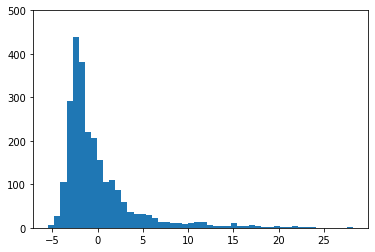

<Figure size 1440x1440 with 0 Axes>

In [43]:
from matplotlib import pyplot as plt
plt.hist(c1, bins=50,)
plt.ylim(0, 500)
# plt.xlim(0, 10)
plt.figure(figsize=(20, 20))
plt.show()

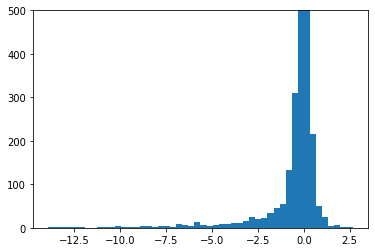

<Figure size 1440x1440 with 0 Axes>

In [44]:
from matplotlib import pyplot as plt
plt.hist(c2, bins=50)
plt.ylim(0, 500)
# plt.xlim(-1, 1)
plt.figure(figsize=(20, 20))
plt.show()